In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import math
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

Let's load a test image to experiment with using the Python Imaging Library (PIL).<br>
Note: PIL images are thenselves objects and the image can be displayed just by printing them

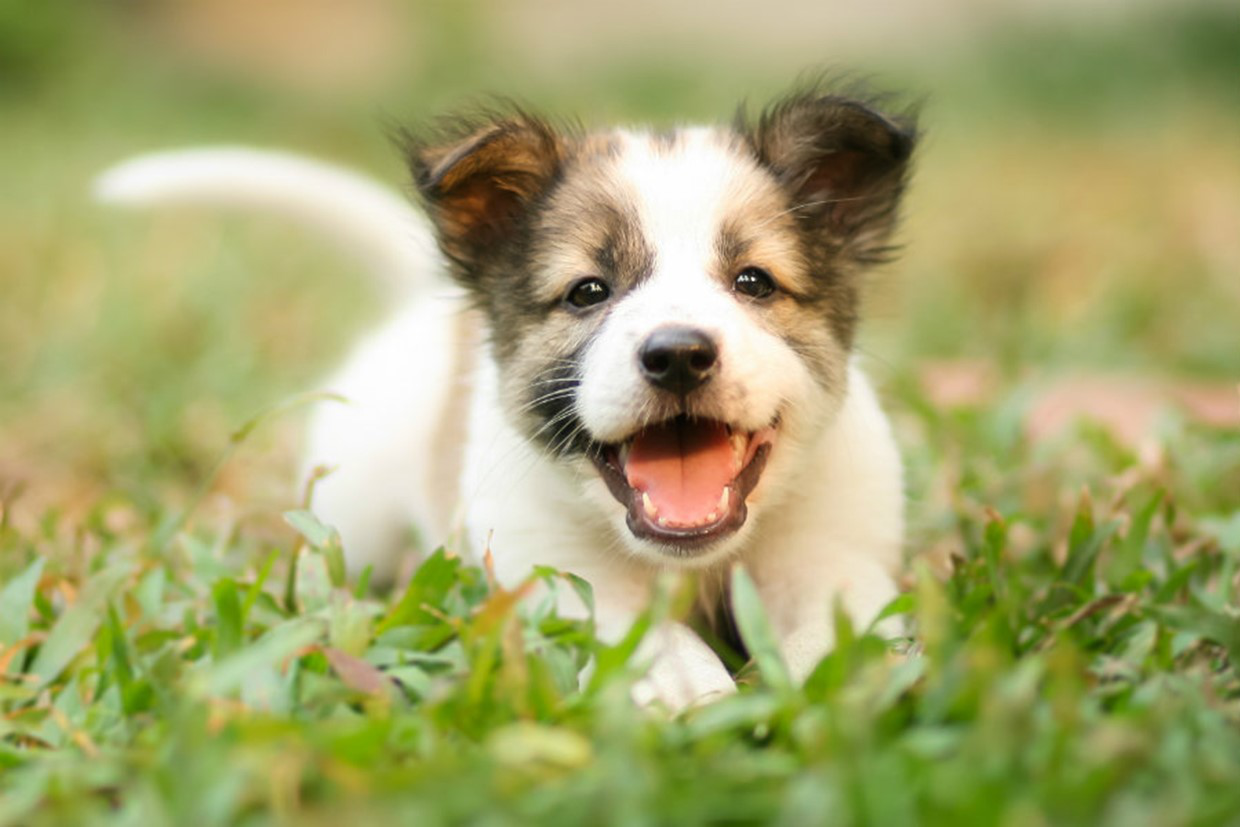

In [10]:
test_img1 = Image.open("puppy.jpg").convert('RGB')
test_img1

In [11]:
# This particular transform simply takes a PIL image and converts it to a tensor
transform = T.ToTensor()
resize = T.Resize(512)
test_img1 = transform(resize(test_img1))
print("Image Shape: ", test_img1.shape)
# NOTE:Many torchvision functions with only work on PIL images

Image Shape:  torch.Size([3, 512, 767])


<h2>Hand Crafted Convolution Kernels</h2>

<h3>Sobel Edge Detector</h3>
The <a href="https://en.wikipedia.org/wiki/Sobel_operator">Sobel Edge detector</a> is a famous and simple convolutional kernal filter that will "extract" the edges of an image and was/is extensively used as a part of many algorithms. Here we will create a Sobel Filter and use it on our test image.<br> By looking at the filter values can you tell how it works?<br><br>
Convolution with a Sobel Kernel (left) and the features extracted by a Sobel edge detector (right)<br>
<img src="https://miro.medium.com/max/1356/1*-OM6jQTMNACDX2vAh_lvMQ.png" width="480" align="left">
<img src="https://upload.wikimedia.org/wikipedia/commons/1/17/Bikesgraysobel.jpg" width="480" align="right">



In [12]:
# First we must create a filter that will extract edges in the X direction
gx = torch.FloatTensor([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]).unsqueeze(0)
gx = torch.repeat_interleave(gx, 3, 0).unsqueeze(0)
print("Kernel Shape: ", gx.shape)
print(gx)

Kernel Shape:  torch.Size([1, 3, 3, 3])
tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]]])


In [13]:
# Now we must create a filter that will extract edges in the Y direction
gy = torch.FloatTensor([[1, 2, 1],[0, 0, 0],[-1, -2, -1]]).unsqueeze(0)
gy = torch.repeat_interleave(gy, 3, 0).unsqueeze(0)
print("Kernel Shape: ", gy.shape)
print(gy)

Kernel Shape:  torch.Size([1, 3, 3, 3])
tensor([[[[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]],

         [[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]],

         [[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]]]])


Feature Map Shape:  torch.Size([1, 1, 510, 765])


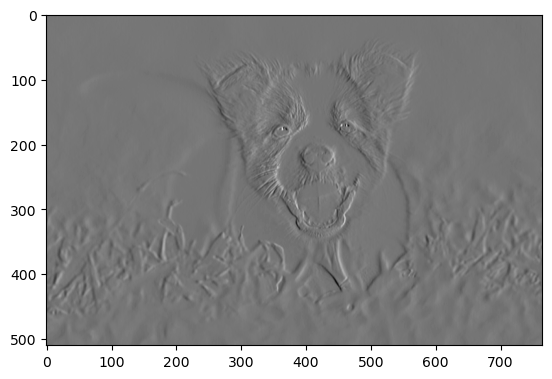

In [14]:
# Convolve the image with the X direction kernel
conv_out1 = F.conv2d(test_img1.unsqueeze(0), gx, bias=None, stride=1)
print("Feature Map Shape: ", conv_out1.shape)

_ = plt.imshow(torch.squeeze(conv_out1), cmap='gray')

Feature Map Shape:  torch.Size([1, 1, 510, 765])


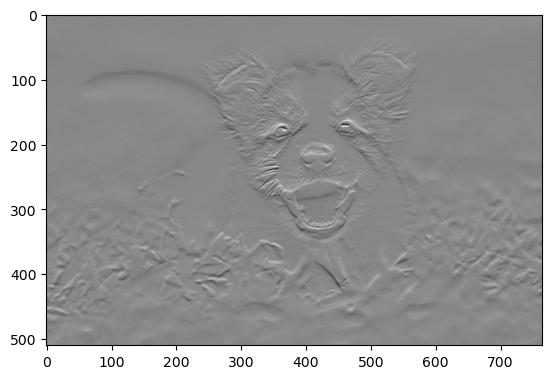

In [15]:
# Convolve the image with the Y direction kernel
conv_out2 = F.conv2d(test_img1.unsqueeze(0), gy, bias=None, stride=1)
print("Feature Map Shape: ", conv_out2.shape)

_ = plt.imshow(torch.squeeze(conv_out2), cmap='gray')

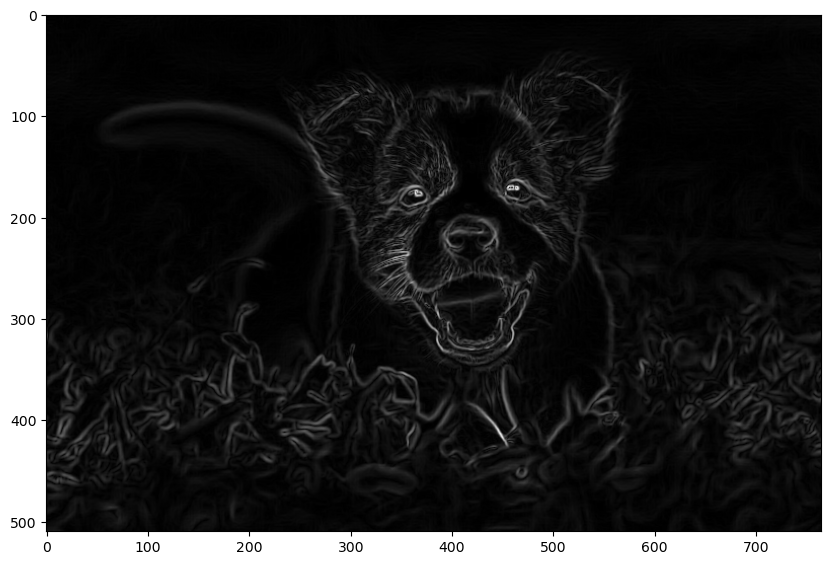

In [16]:
# Combine the two resulting images together by finding the magnitude
conv_out = (conv_out1.pow(2) + conv_out2.pow(2)).sqrt()
plt.figure(figsize = (10,10))
_ = plt.imshow(conv_out.squeeze(), cmap='gray')

<h3>Convolutional layers </h3>
Instead of doing each convolution separately, we can concatenate the kernels and perform the convolution with both kernels in one step! The ouput will have the 2D feature maps from each kernel concatenated along the channel dimension!

torch.Size([2, 3, 3, 3])
torch.Size([1, 2, 510, 765])


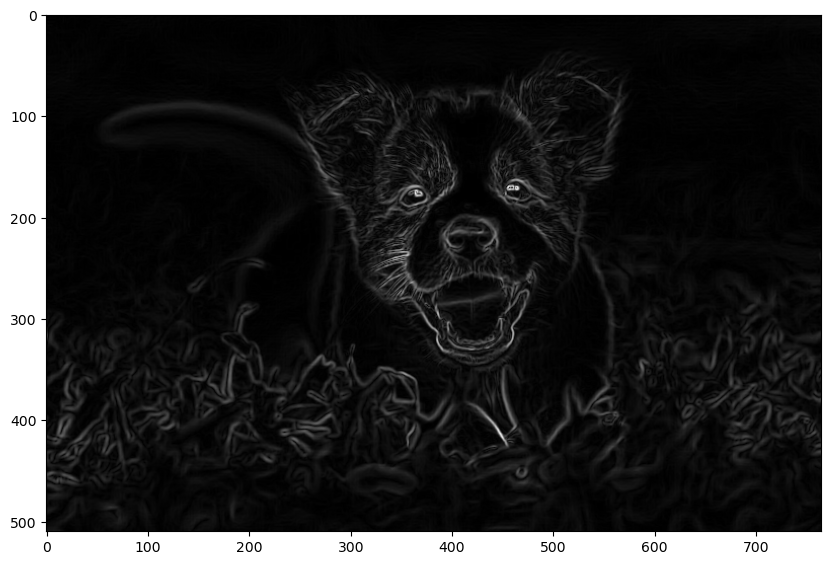

In [18]:
# Concatenate both kernels 
g_xy = torch.cat((gx, gy), 0)
print(g_xy.shape)

# We can perform the convolutions of both kernels in the same step
conv_out3 = F.conv2d(test_img1.unsqueeze(0), g_xy, bias=None, stride=1)

print(conv_out3.shape)
# We can now easily find the magnitude
conv_out_mag = conv_out3.pow(2).sum(1).sqrt()

# We should get the same output as before!
plt.figure(figsize = (10,10))
_ = plt.imshow(conv_out_mag.squeeze(), cmap='gray')

In [20]:
# Lets create a learnable 2D convolutional layer
# in_channels  - The number of input channels
# out_channels - The number of output channels - also the number of filters in a layer
# kernel_size  - The height and width of our kernel - can specify with a tuple for non-square kernels
# stride       - The number of pixels the kernel will "step"
# bias         - Same as a linear layer, 1 bias term per output channel

conv_kernel = nn.Conv2d(in_channels = 3, out_channels = 1, 
                        kernel_size = 3, stride = 1, padding = 1, bias = False)

# Define an optimizer
optimizer = optim.SGD(conv_kernel.parameters(), lr = 1e-2)

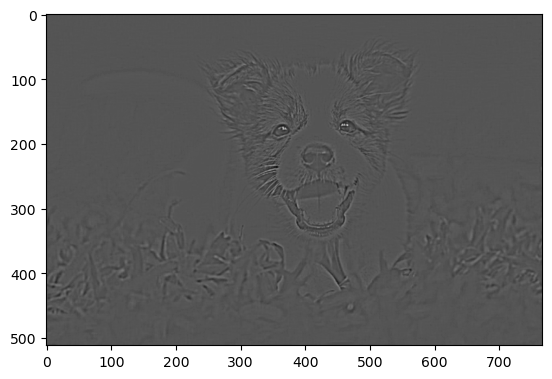

In [23]:
# Create a target
# Blur the image and subtract this from the original
# Blurring will leave only the high frequency components on the image
# By subtracting them from the original we should get only the high frequency components
blur = T.GaussianBlur(7, 4)
target = test_img1.unsqueeze(0) - blur(test_img1.unsqueeze(0))
_ = plt.imshow(torch.squeeze(target[0, 0]), cmap='gray')

In [24]:
logger = []

for _ in trange(2000):
    imgs_out = conv_kernel(test_img1.unsqueeze(0))

    loss = (target - imgs_out).pow(2).mean()
    logger.append(loss.item())
    conv_kernel.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

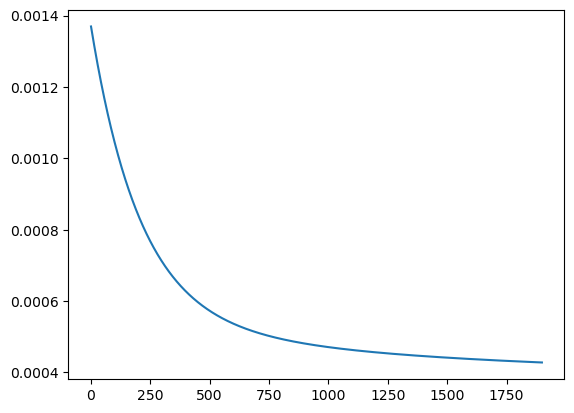

In [25]:
plt.plot(logger[100:])

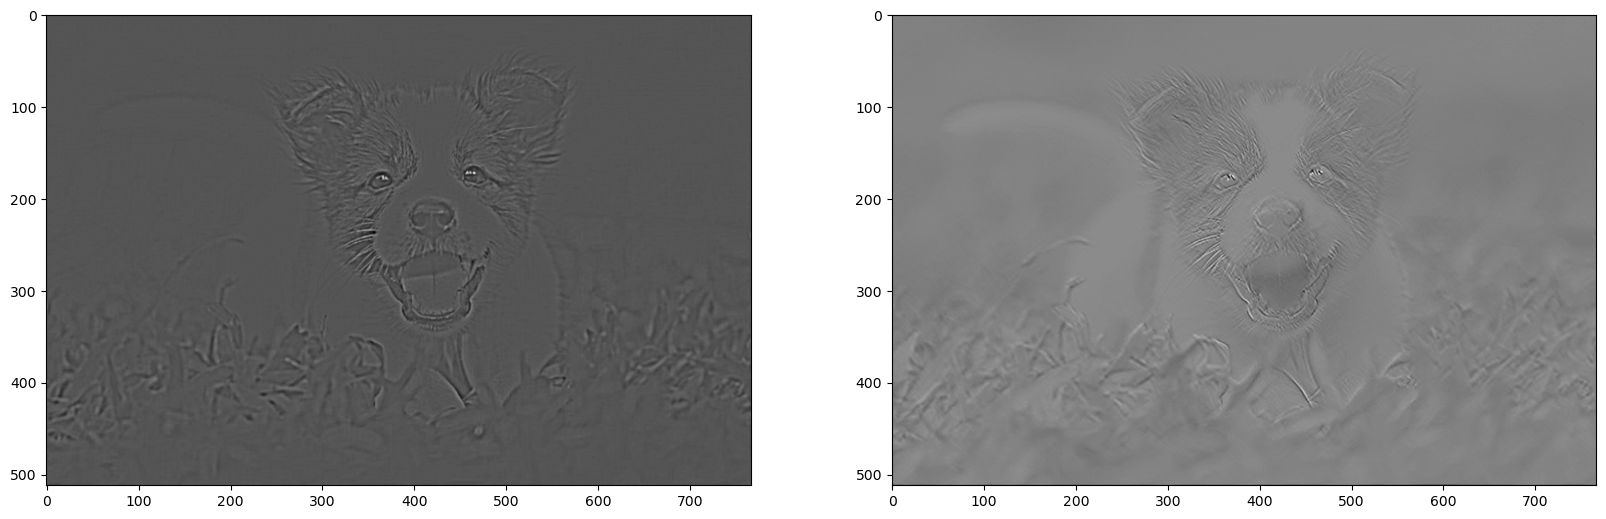

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize = (20,10))
ax2.imshow(torch.squeeze(imgs_out[0, 0].detach()), cmap='gray')
ax1.imshow(torch.squeeze(target[0, 0]), cmap='gray')